In [ ]:
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/timser/v0.1/train.csv
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/timser/v0.1/val.csv

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import datetime as dt
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tools.eval_measures import rmse

In [ ]:
import math
import numpy as np
import datetime as dt
# from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tools.eval_measures import rmse

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# !pip install pytorchts
!pip install nsepy
!pip install pmdarima

In [ ]:
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [ ]:
train =  pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
sample = pd.read_csv('sample_submission.csv')

In [ ]:
total_log = pd.concat([train,val])

In [ ]:
train.date = pd.to_datetime(train.date,format='%Y-%m-%d')
train = train.set_index("date")
train.head(10)

,value
date,
1985-01-29,1552.519959
1985-01-30,1576.070007
1985-01-31,1561.440002
1985-02-01,1554.839935
1985-02-04,1550.879944
1985-02-05,1575.860047
1985-02-06,1568.690003
1985-02-07,1570.500000
1985-02-08,1577.879944


In [ ]:
train = total_log

In [ ]:
val.date = pd.to_datetime(val.date,format='%Y-%m-%d')
val = val.set_index("date")
val.head(10)

,value
date,
2010-03-26,13248.020019
2010-03-29,13253.000489
2010-03-30,13301.709472
2010-03-31,13310.319824
2010-04-01,13268.989502
2010-04-05,13336.930175
2010-04-06,13392.820312
2010-04-07,13395.050293
2010-04-08,13320.980224


In [ ]:
train["year"] = train.index.year
train["month"] =train.index.month
train["day"] = train.index.day

# val["year"] = val.index.year
# val["month"] = val.index.month
# val["day"] = val.index.day


AttributeError: ignored

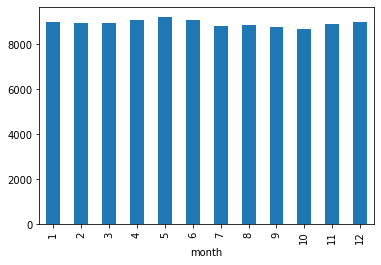

In [ ]:
train.groupby('month')['value'].mean().plot.bar()


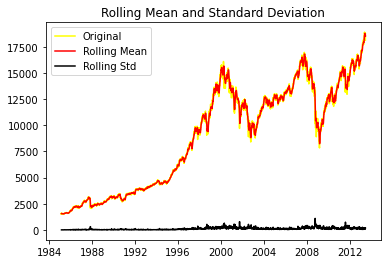

Results of dickey fuller test
Test Statistics                  -0.459593
p-value                           0.899663
No. of lags used                 34.000000
Number of observations used    7125.000000
critical value (1%)              -3.431268
critical value (5%)              -2.861946
critical value (10%)             -2.566986
dtype: float64


In [ ]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(train['value'])
# test_stationarity(val['value'])

<function matplotlib.pyplot.show>

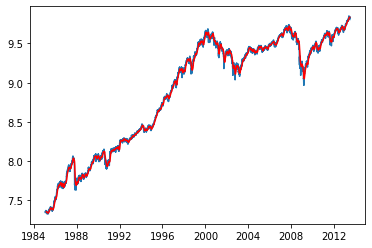

In [ ]:
train_log = np.log(train['value']) 
test_log = np.log(val['value'])
moving_avg = train_log.rolling(24).mean() 
plt.plot(train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show

In [ ]:
train_log

date
1985-01-29    7.347635
1985-01-30    7.362690
1985-01-31    7.353364
1985-02-01    7.349128
1985-02-04    7.346578
                ...   
2013-06-17    9.827075
2013-06-18    9.833204
2013-06-19    9.841562
2013-06-20    9.826102
2013-06-21    9.805237
Name: value, Length: 7160, dtype: float64

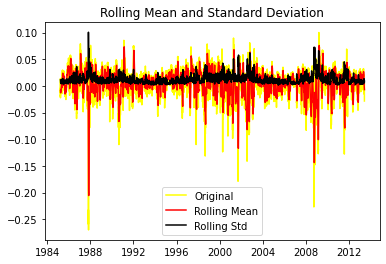

Results of dickey fuller test
Test Statistics               -1.235212e+01
p-value                        5.794059e-23
No. of lags used               3.400000e+01
Number of observations used    7.102000e+03
critical value (1%)           -3.431271e+00
critical value (5%)           -2.861947e+00
critical value (10%)          -2.566987e+00
dtype: float64


(None, None)

In [ ]:
train_log_moving_avg_diff = train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True), test_stationarity(train_log_moving_avg_diff)


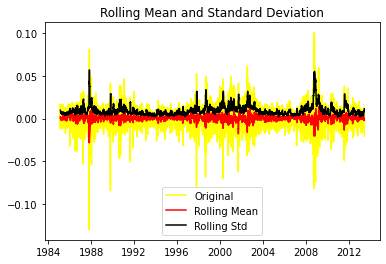

Results of dickey fuller test
Test Statistics               -1.447444e+01
p-value                        6.524561e-27
No. of lags used               3.300000e+01
Number of observations used    7.125000e+03
critical value (1%)           -3.431268e+00
critical value (5%)           -2.861946e+00
critical value (10%)          -2.566986e+00
dtype: float64


In [ ]:
train_log_diff = train_log - train_log.shift(1) 
test_stationarity(train_log_diff.dropna())


In [ ]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_log)
forecast = model.predict(n_periods=len(sample))
forecast = pd.DataFrame(forecast,index = sample['date'],columns=['value'])
#plot the predictions for validation set
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(forecast, label='Prediction')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
print(train.iloc[0]['value']/train_log[0])
print(train.iloc[1]['value']/train_log[1])
print(train.iloc[2]['value']/train_log[2])
print(train.iloc[3]['value']/train_log[3])



211.29520298400206
214.06171838474623
212.34363680597045
211.56795195586193


In [ ]:
forecast = forecast.reset_index()

In [ ]:
# forecast = forecast.rename(columns = {'Prediction':'value'})
forecast.head(10)

,date,value
0,2013-06-24,9.806811
1,2013-06-25,9.807536
2,2013-06-26,9.807006
3,2013-06-27,9.807487
4,2013-06-28,9.808263
5,2013-07-01,9.808338
6,2013-07-02,9.808536
7,2013-07-03,9.809084
8,2013-07-05,9.809416
9,2013-07-08,9.809638


In [ ]:
test = pd.DataFrame(columns=['date','value'])
start = dt.date( 2013, 6, 24 )
end = dt.date( 2021, 1, 13 )
weekdays = [6,7]
for dt in daterange(start, end):
    if dt.isoweekday() not in weekdays:
        test.loc[len(test)]= [dt.strftime("%Y-%m-%d")," "]

In [ ]:
test['value']=forecast['Prediction']

In [ ]:
forecast['value'] = np.exp(forecast['value'])

In [ ]:
forecast.to_csv('timser_baseline.csv')

In [ ]:
forecast.head(10)

,date,value
0,2013-06-24,18156.994670
1,2013-06-25,18170.156313
2,2013-06-26,18160.537515
3,2013-06-27,18169.261665
4,2013-06-28,18183.372390
5,2013-07-01,18184.735412
6,2013-07-02,18188.342734
7,2013-07-03,18198.315384
8,2013-07-05,18204.349508
9,2013-07-08,18208.387784


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test_log,forecast))
print("RMSE: ", rms)

RMSE:  0.04993564667744231


In [ ]:
2,760 days - test data generation
1,183 days - val data days
~ 8,969 days - train data days

In [ ]:
sample = pd.read_csv('/content/sample_submission (3).csv')
sample.date.to_list()

In [ ]:
t = pd.DataFrame(data={'date':sample.date.to_list,'value':[]})